In [119]:
import matplotlib.pyplot as plt
import os
import cv2
import matplotlib.image as mpimg
import shutil
import xmltodict
import numpy as np 

In [204]:
data_dir1 = "./Data/archive/DAGM_dataset/Class1/Train/"
data_dir2 = "./Data/archive/DAGM_dataset/Class2/Train/"
data_dir3 = "./Data/archive/DAGM_dataset/Class3/Train/"
data_dir4 = "./Data/archive/DAGM_dataset/Class4/Train/"
data_dir5 = "./Data/archive/DAGM_dataset/Class5/Train/"
data_dir6 = "./Data/archive/DAGM_dataset/Class6/Train/"

tdata_dir = "./Data/archive/DAGM_dataset/Class1/Train/"

In [214]:
def get_mask_seg_ellipse(path_to_img):
    # get the image

    img = mpimg.imread(path_to_img)
    basename = os.path.basename(path_to_img)

    # filename_index, e.g. filename = 1.png
    # filename_index = 1, for extracting coordinates
    filename_index = int(os.path.splitext(basename)[0]) - 1
    # print(filename_index)

    
    path_to_coordinates = path_to_img.replace(basename, 'Label')
    #print(path_to_coordinates)
    path_to_coordinates = os.path.join(path_to_coordinates,'Labels.txt')
    #print(path_to_coordinates)
    coordinates,ret = load_coordinates(path_to_coordinates)
    
    
    
    if(coordinates[filename_index]['is_defect']==1):
        mask=mpimg.imread(path_to_coordinates.replace('Labels.txt', coordinates[filename_index]['coord']))
    else:
        mask=np.zeros_like(img)
    # print(coordinates[filename_index]['angle'])

    return mask

def get_coordinates(path_to_label, xml):

    with open(path_to_label, encoding='utf-8') as f:
        if xml:
            label_xml = xmltodict.parse(f.read())

            # print(type(label_xml))
            # print(label_xml)

            coordinates_object = label_xml['annotation']['object']
        else:
            label_txt = f.read()
            coordinates_object = label_txt.strip().split('\n')

    return coordinates_object

def load_coordinates(path_to_coor):

    coord_dict = {}
    coord_dict_all = {}
    defect_pic=[]
    with open(path_to_coor) as f:
        coordinates = f.read().split('\n')
        for coord in coordinates:
            # print(len(coord.split('\t')))
            if len(coord.split('\t')) == 5:
                coord_dict = {}
                coord_split = coord.split('\t')
                # print(coord_split)
                # print('\n')
                coord_dict['is_defect'] = round(float(coord_split[1]))
                coord_dict['name'] = coord_split[2]
                coord_dict['unknown'] = float(coord_split[3])
                coord_dict['coord'] = coord_split[4]
                index = int(coord_split[0]) - 1
                defect_pic.append(index)
                coord_dict_all[index] = coord_dict

            if len(coord.split('\t')) == 6:
                coord_dict = {}
                coord_split = coord.split('\t')
                coord_dict['is_defect'] = round(float(coord_split[1]))
                coord_dict['name'] = coord_split[2]
                coord_dict['unknown'] = float(coord_split[3])
                coord_dict['coord'] = coord_split[5]
                index = int(coord_split[0]) - 1
                coord_dict_all[index] = coord_dict

    return coord_dict_all,defect_pic

def plot_ellipse_seg_test(path_to_img):

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)

    plt.imshow(mpimg.imread(path_to_img), cmap='gray')
    plt.subplot(1, 2, 2)
    mask = get_mask_seg_ellipse(path_to_img)
    plt.imshow(mask, cmap='gray')
    
#plot_ellipse_seg_test(os.path.join(data_dir2, "0576.png"))

IMAGE_CHANNELS = 1

def load_images_masks(path_to_images, img_type, img_format, resize):

    imgflag,pic_index=load_coordinates(os.path.join(path_to_images,"Label","Labels.txt"))
    image_names = [x for x in os.listdir(path_to_images) if x.endswith(img_type)]
    image_names = [x for x in image_names if int(x.split(".")[0])-1 in pic_index]
    #print(x.split(".")[0])

    image_num = len(image_names)
    images_all = np.empty([image_num, resize[0], resize[1], IMAGE_CHANNELS])
    labels_all = np.empty([image_num, resize[0], resize[1], IMAGE_CHANNELS])

    for image_index in range(image_num):
        image_filename = image_names[image_index]
        # print(image_filename)
        # print(image_filename)
        image = mpimg.imread(os.path.join(path_to_images, image_filename), format=img_format)
        mask = get_mask_seg_ellipse(os.path.join(path_to_images, image_filename))

        if resize:
            image = cv2.resize(image, (resize[0], resize[1]))
            mask = cv2.resize(mask, (resize[0], resize[1]))

        images_all[image_index] = np.reshape(image, (resize[0], resize[1], IMAGE_CHANNELS))
        labels_all[image_index] = np.reshape(mask, (resize[0], resize[1], IMAGE_CHANNELS))

    return images_all, labels_all

In [215]:
X1, y1 = load_images_masks(data_dir1, img_type='PNG', img_format='gray', resize=(512, 512))
# X2, y2 = load_images_masks(data_dir2, img_type='PNG', img_format='gray', resize=(512, 512))
# X3, y3 = load_images_masks(data_dir3, img_type='PNG', img_format='gray', resize=(512, 512))
# X4, y4 = load_images_masks(data_dir4, img_type='PNG', img_format='gray', resize=(512, 512))
# X5, y5 = load_images_masks(data_dir5, img_type='PNG', img_format='gray', resize=(512, 512))
# X6, y6 = load_images_masks(data_dir6, img_type='PNG', img_format='gray', resize=(512, 512))

In [231]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from scipy.ndimage.measurements import label
import time


def small_unet():
    inputs = Input((512,512, 1))
    #inputs_norm = Lambda(lambda x: x/127.5 - 1.)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(64, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(32, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(16, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(8, kernel_size=(
        2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    return model


model1 = small_unet()
model2 = small_unet()
model3 = small_unet()
model4 = small_unet()
model5 = small_unet()
model6 = small_unet()


def smooth_dice_coeff(smooth=1.):

    smooth = float(smooth)

    # IOU or dice coeff calculation
    def IOU_calc(y_true, y_pred):
            y_true_f = K.flatten(y_true)
            y_pred_f = K.flatten(y_pred)
            intersection = K.sum(y_true_f * y_pred_f)

            return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    def IOU_calc_loss(y_true, y_pred):
        return -IOU_calc(y_true, y_pred)
    return IOU_calc, IOU_calc_loss

IOU_calc, IOU_calc_loss = smooth_dice_coeff(0.00001)


model1.compile(optimizer= Adam(learning_rate=0.0001),loss= IOU_calc_loss )
# model2.compile(optimizer= Adam(learning_rate=0.0001),loss= IOU_calc_loss )
# model3.compile(optimizer= Adam(learning_rate=0.0001),loss= IOU_calc_loss )
# model4.compile(optimizer= Adam(learning_rate=0.0001),loss= IOU_calc_loss )
# model5.compile(optimizer= Adam(learning_rate=0.0001),loss= IOU_calc_loss )
# model6.compile(optimizer= Adam(learning_rate=0.0001),loss= IOU_calc_loss )

import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
x_train1, x_valid1, y_train1, y_valid1 = train_test_split(X1, y1, test_size=0.16666,  shuffle= True)
# x_train2, x_valid2, y_train2, y_valid2 = train_test_split(X2, y2, test_size=0.16666,  shuffle= True)
# x_train3, x_valid3, y_train3, y_valid3 = train_test_split(X3, y3, test_size=0.16666,  shuffle= True)
# x_train4, x_valid4, y_train4, y_valid4 = train_test_split(X4, y4, test_size=0.16666,  shuffle= True)
# x_train5, x_valid5, y_train5, y_valid5 = train_test_split(X5, y5, test_size=0.16666,  shuffle= True)
# x_train6, x_valid6, y_train6, y_valid6 = train_test_split(X6, y6, test_size=0.16666,  shuffle= True)


callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model1.fit(x_train1, y_train1, batch_size=10, epochs=25,callbacks=[callback],validation_data = (x_valid1,y_valid1), verbose=1)
model1.save('./model/class1.h5')
# history = model2.fit(x_train2, y_train2, batch_size=10, epochs=25,callbacks=[callback],validation_data = (x_valid2,y_valid2), verbose=1)
# model2.save('./model/class2.h5')
# history = model3.fit(x_train3, y_train3, batch_size=10, epochs=25,validation_data = (x_valid3,y_valid3),callbacks=[callback], verbose=1)
# model3.save('./model/class3.h5')
# history = model4.fit(x_train4, y_train4, batch_size=10, epochs=25,callbacks=[callback],validation_data = (x_valid4,y_valid4), verbose=1)
# model4.save('./model/class4.h5')
# history = model5.fit(x_train5, y_train5, batch_size=10, epochs=25,callbacks=[callback],validation_data = (x_valid5,y_valid5), verbose=1)
# model5.save('./model/class5.h5')
# history = model6.fit(x_train6, y_train6, batch_size=10, epochs=25,callbacks=[callback],validation_data = (x_valid6,y_valid6), verbose=1)
# model6.save('./model/class6.h5')


7/7 [==============================] - 49s 6s/step - loss: -0.0682 - val_loss: -0.0625


In [5]:

import tensorflow as tf

color_mode = "grayscale"
number_colour_layers = 1
image_size = (512, 512)
image_shape = image_size + (number_colour_layers,)

image_shape

training_data_path = "./Data/archive/DAGM_dataset/Class1/Train"
#test_data_path = "./casting_data/casting_data/test"
SEED = 42

def get_image_data(data_path, color_mode, image_size, seed = None):

    return tf.keras.preprocessing.image_dataset_from_directory(
        data_path,
        color_mode=color_mode,
        image_size=image_size,
        seed=seed,
        batch_size=6
    )


training_ds = get_image_data(
    training_data_path,
    color_mode,
    image_size,
    SEED
)


preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(512,512,1))
]


def conv_2d_pooling_layers(filters, number_colour_layers):
    return [
        tf.keras.layers.Conv2D(
            filters,
            number_colour_layers,
            padding='same',
            activation='relu'
        ),
        tf.keras.layers.MaxPooling2D()
    ]
core_layers =     conv_2d_pooling_layers(8, number_colour_layers) +     conv_2d_pooling_layers(16, number_colour_layers) +     conv_2d_pooling_layers(32, number_colour_layers)


class_names = training_ds.class_names
number_classes = len(class_names)
dense_layers = [
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(number_classes)
]

model = tf.keras.Sequential(
    preprocessing_layers +
    core_layers +
    dense_layers
)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer='adam',
    loss=loss,
    metrics=['accuracy']
)



callback = tf.keras.callbacks.EarlyStopping(
    monitor='acc', patience=3, mode='auto'
)



history = model.fit(
    training_ds,epochs = 4,callbacks = [callback]
)


model.save("./model/2Wobot1_train_model.h5")

Found 79 files belonging to 1 classes.
Epoch 1/4
14/14 [==============================] - 5s 293ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2/4
14/14 [==============================] - 4s 307ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3/4
14/14 [==============================] - 4s 267ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4/4
14/14 [==============================] - 4s 295ms/step - loss: 0.0000e+00 - accuracy: 1.0000


In [37]:
import tensorflow as tf
import numpy as np
import os
import re 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image

model1 = tf.keras.models.load_model("./model/class1.h5",compile=False)
model2 = tf.keras.models.load_model("./model/class2.h5",compile=False)
model3 = tf.keras.models.load_model("./model/class3.h5",compile=False)
model4 = tf.keras.models.load_model("./model/class4.h5",compile=False)
model5 = tf.keras.models.load_model("./model/class5.h5",compile=False)
model6 = tf.keras.models.load_model("./model/class6.h5",compile=False)

model_class2 = tf.keras.models.load_model("./model/2Wobot1_train_model.h5")

import matplotlib.pyplot as plt


IMAGE_CHANNELS = 1

def load_images(path_to_images, img_type, img_format, resize):

    image_names = [x for x in os.listdir(path_to_images) if x.endswith(img_type)]

    image_num = len(image_names)
    images_all = np.empty([image_num, resize[0], resize[1], IMAGE_CHANNELS])

    for image_index in range(image_num):
        # image_filename = image_names[image_index]
        # regex = re.compile(r'\d+')

        # filenameidx =[int(x) for x in regex.findall(image_filename)]

        # image = mpimg.imread(os.path.join(path_to_images, image_filename), format=img_format)
        

        # if resize:
        #     image = cv2.resize(image, (resize[0], resize[1]))
      
        # images_all[int(filenameidx[0])-1] = np.reshape(image, (resize[0], resize[1], IMAGE_CHANNELS))
        image_filename = image_names[image_index]
        # print(image_filename)
        # print(image_filename)
        image = mpimg.imread(os.path.join(path_to_images, image_filename), format=img_format)

        if resize:
            image = cv2.resize(image, (resize[0], resize[1]))

        images_all[image_index] = np.reshape(image, (resize[0], resize[1], IMAGE_CHANNELS))   

    return images_all

In [2]:
dir = "./Data/archive/DAGM_dataset/Class1/Test"
Xt= load_images(dir, img_type='PNG', img_format='gray', resize=(512, 512))

18/18 [==============================] - 10s 404ms/step


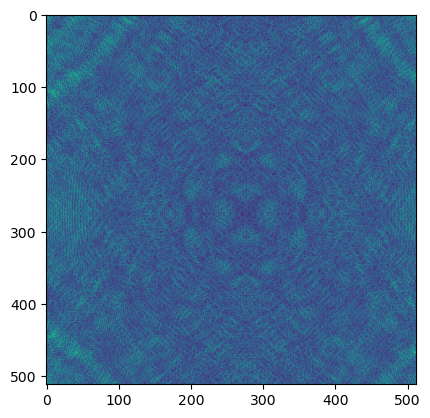

In [38]:
ac1 = model1.predict(Xt)
#ac2 = model2.predict(Xt)
#ac3 = model3.predict(Xt)
#ac4 = model4.predict(Xt)
#ac5 = model5.predict(Xt)
#ac6 = model6.predict(Xt)

predictions = model_class2.predict(Xt)

#predictions
score = tf.nn.softmax(predictions)
scorearr = np.array(score)
x = scorearr.argmax(axis = 1)[:,None]
x.shape

pred=[]
a = 0
for i in x:
  if(i==0):
    predict = ac1[a,:,:,0]
  elif(i==1):
    predict = ac2[a,:,:,0]
  elif(i==2):
    predict = ac3[a,:,:,0]
  elif(i==3):
    predict = ac4[a,:,:,0]
  elif(i==4):
    predict = ac5[a,:,:,0]
  elif(i==5):
    predict = ac6[a,:,:,0]
  else:
    print("Error")

  pred.append(predict)
  a +=1
    
predarr = np.array(pred)

plt.imshow(predarr[3,:,:])

plt.imshow(Xt[0,:,:,0])

from PIL import Image
import numpy as np
for i in range(120):
  col = Image.fromarray(predarr[i,:,:]*255)
  gray = col.convert('L')

# Let numpy do the heavy lifting for converting pixels to pure black or white
  bw = np.asarray(gray).copy()

# Pixel range is 0...255, 256/2 = 128
  bw[bw < 128] = 0   # Black
  bw[bw >= 128] = 255 # White

# Now we put it back in Pillow/PIL land
  imfile = Image.fromarray(bw)
  imfile.save("./picture/{0}.jpeg".format(i+1))


#Just to confirm that 2Wobot1_train_model.h5 is working
intx = x.astype(int)
np.savetxt("Testindex.txt", intx, fmt='% d')

In [ ]:
image = test_images[image_index]
mask = predicted_masks[image_index]

# If the image is grayscale, ensure it has 3 channels for RGB
if len(image.shape) == 2:  # if image is grayscale
    image = np.stack([image]*3, axis=-1)

# Create the overlay by combining the image and the mask
plt.figure(figsize=(8, 8))

# Display the original image
plt.imshow(image, cmap='gray')

# Overlay the mask (use alpha to control transparency)
plt.imshow(mask, cmap='jet', alpha=0.5)  # 'jet' colormap adds color to the mask

plt.title('Image with Mask Overlay')
plt.axis('off')
plt.show()